Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

Get the dataset

In [ ]:
df = pd.read_csv('/content/Mental-Health-Twitter.csv')
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
post_id,0
post_created,0
post_text,0
user_id,0
followers,0
friends,0
favourites,0
statuses,0
retweets,0


Clearly there are no missing values in the dataset. But in case if missing values occur we can use certain methods like:
- deleting the rows with missing values
- deleting the column with too many missing values
- filling the missing values with mean, median or mode of the column
- using machine learning algorithms to predict the missing values for ex using regression to predict the missing values of a column.
- using clustering algorithms to group the data points with missing values and then using the mean of the cluster to fill the missing values.
- flag the missing values as a separate category.

 Now let's drop irrelevant columns from the dataset. The 'Unnamed: 0' here is the extra column which is not required for our analysis. So we will drop it. Also the 'id' column is not required for our analysis as it is just a unique identifier for each row. So we will drop it too.

In [ ]:
df.drop(columns=['Unnamed: 0', 'post_id', 'user_id'], inplace=True)
df.head()

,post_created,post_text,followers,friends,favourites,statuses,retweets,label
0,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1
1,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1
2,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1
3,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1
4,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1


Convert the time to post creation to datetime format and use seperate columns for year, month and day.

In [ ]:
df.post_created=df.post_created.apply(pd.to_datetime)

df["month"]=df.post_created.dt.month
df["year"]=df.post_created.dt.year
df["day"]=df.post_created.dt.day

df.drop("post_created", axis=1)
df.head()

,post_created,post_text,followers,friends,favourites,statuses,retweets,label,month,year,day
0,2015-08-30 07:48:37+00:00,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1,8,2015,30
1,2015-08-30 07:31:33+00:00,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1,8,2015,30
2,2015-08-29 22:11:07+00:00,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1,8,2015,29
3,2015-08-29 18:40:49+00:00,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1,8,2015,29
4,2015-08-29 18:40:26+00:00,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1,8,2015,29


Find the pearson correlation coefficient between the variables.

- For r = 1, there is a perfect positive correlation between the variables.
- For 0 < r < 1 there is a positive correlation between the variables.
- For r = 0, there is no correlation between the variables.
- For -1 < r < 0 there is a negative correlation between the variables.
- For r = -1, there is a perfect negative correlation between the variables.

In [ ]:
# Select only the desired columns for correlation
selected_columns = ['followers', 'friends', 'favourites', 'statuses', 'retweets', 'label', 'month', 'year', 'day']
corr_matrix = df[selected_columns].corr()

# Display the correlation matrix
print(corr_matrix)


            followers   friends  favourites  statuses  retweets     label  \
followers    1.000000  0.891919   -0.016242 -0.000215  0.001500 -0.011181   
friends      0.891919  1.000000   -0.081756 -0.045420  0.009946  0.119818   
favourites  -0.016242 -0.081756    1.000000 -0.053930  0.069551 -0.252289   
statuses    -0.000215 -0.045420   -0.053930  1.000000 -0.005193 -0.246473   
retweets     0.001500  0.009946    0.069551 -0.005193  1.000000 -0.025198   
label       -0.011181  0.119818   -0.252289 -0.246473 -0.025198  1.000000   
month       -0.058929 -0.002305    0.115795 -0.143243  0.012950  0.038826   
year        -0.006601 -0.038264    0.240273  0.213416  0.025722 -0.680997   
day          0.001158  0.035300    0.001036 -0.053027  0.018179  0.105365   

               month      year       day  
followers  -0.058929 -0.006601  0.001158  
friends    -0.002305 -0.038264  0.035300  
favourites  0.115795  0.240273  0.001036  
statuses   -0.143243  0.213416 -0.053027  
retweets    0.

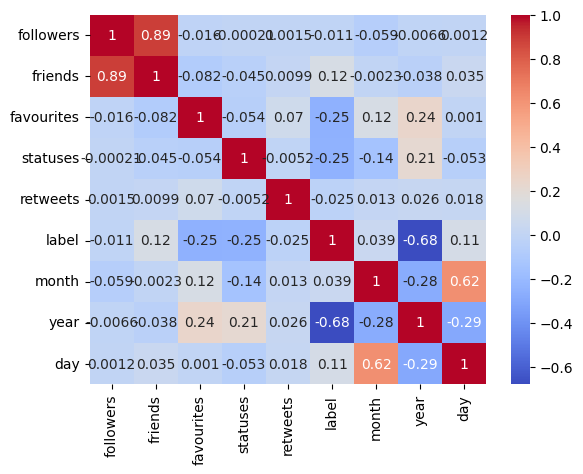

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df.head(10)

,post_created,post_text,followers,friends,favourites,statuses,retweets,label,month,year,day
0,2015-08-30 07:48:37+00:00,It's just over 2 years since I was diagnosed w...,84,211,251,837,0,1,8,2015,30
1,2015-08-30 07:31:33+00:00,"It's Sunday, I need a break, so I'm planning t...",84,211,251,837,1,1,8,2015,30
2,2015-08-29 22:11:07+00:00,Awake but tired. I need to sleep but my brain ...,84,211,251,837,0,1,8,2015,29
3,2015-08-29 18:40:49+00:00,RT @SewHQ: #Retro bears make perfect gifts and...,84,211,251,837,2,1,8,2015,29
4,2015-08-29 18:40:26+00:00,It’s hard to say whether packing lists are mak...,84,211,251,837,1,1,8,2015,29
5,2015-08-29 18:26:24+00:00,Making packing lists is my new hobby... #movin...,84,211,251,837,1,1,8,2015,29
6,2015-08-29 18:21:51+00:00,At what point does keeping stuff for nostalgic...,84,211,251,837,1,1,8,2015,29
7,2015-08-29 18:12:59+00:00,Currently in the finding-boxes-of-random-shit ...,84,211,251,837,0,1,8,2015,29
8,2015-08-29 18:04:05+00:00,"Can't be bothered to cook, take away on the wa...",84,211,251,837,0,1,8,2015,29
9,2015-08-29 17:54:54+00:00,RT @itventsnews: ITV releases promo video for ...,84,211,251,837,41,1,8,2015,29


In [ ]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
import pandas as pd
import numpy as np

# Select the specific columns for correlation
selected_columns = ['followers', 'friends', 'favourites', 'statuses', 'retweets', 'label', 'month', 'year', 'day']
df_selected = df[selected_columns]

# Calculate the correlation matrix
corr_matrix = df_selected.corr().abs()

# Set the correlation threshold
threshold = 0.85

# Select the upper triangle of the correlation matrix to avoid redundancy
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation above the threshold
corr_features = [column for column in upper.columns if any(upper[column] > threshold)]

# Display correlated features and correlation values
print("Highly correlated features (above threshold of 0.85):")
for column in corr_features:
    highly_correlated = upper[column][upper[column] > threshold]
    print(f"\nFeature '{column}' is highly correlated with:")
    print(highly_correlated)


Highly correlated features (above threshold of 0.85):

Feature 'friends' is highly correlated with:
followers    0.891919
Name: friends, dtype: float64


In [ ]:
df = df.drop(columns=corr_features)
df

,post_created,post_text,followers,favourites,statuses,retweets,label,month,year,day
0,2015-08-30 07:48:37+00:00,It's just over 2 years since I was diagnosed w...,84,251,837,0,1,8,2015,30
1,2015-08-30 07:31:33+00:00,"It's Sunday, I need a break, so I'm planning t...",84,251,837,1,1,8,2015,30
2,2015-08-29 22:11:07+00:00,Awake but tired. I need to sleep but my brain ...,84,251,837,0,1,8,2015,29
3,2015-08-29 18:40:49+00:00,RT @SewHQ: #Retro bears make perfect gifts and...,84,251,837,2,1,8,2015,29
4,2015-08-29 18:40:26+00:00,It’s hard to say whether packing lists are mak...,84,251,837,1,1,8,2015,29
...,...,...,...,...,...,...,...,...,...,...
19995,2017-01-12 00:14:56+00:00,A day without sunshine is like night.,442,7,1063601,0,0,1,2017,12
19996,2017-01-12 00:06:18+00:00,"Boren's Laws: (1) When in charge, ponder. (2) ...",442,7,1063601,0,0,1,2017,12
19997,2017-01-12 00:05:42+00:00,The flow chart is a most thoroughly oversold p...,442,7,1063601,0,0,1,2017,12
19998,2017-01-12 00:05:22+00:00,"Ships are safe in harbor, but they were never ...",442,7,1063601,0,0,1,2017,12


Since Friends and Followers are highly correlated, we have dropped the Friends column.

In [ ]:
df.describe()

,followers,favourites,statuses,retweets,label,month,year,day
count,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,900.483950,6398.235550,4.439442e+04,1437.927300,0.500000,6.711350,2015.485950,16.202050
std,1899.913961,8393.072914,1.407785e+05,15119.665118,0.500013,4.735351,1.485434,9.218171
min,0.000000,0.000000,3.000000e+00,0.000000,0.000000,1.000000,2009.000000,1.000000
25%,177.000000,243.000000,5.129000e+03,0.000000,0.000000,1.000000,2015.000000,8.000000
50%,476.000000,2752.000000,1.325100e+04,0.000000,0.500000,8.000000,2016.000000,17.000000
75%,1197.000000,8229.000000,5.289200e+04,1.000000,1.000000,12.000000,2016.000000,24.000000
max,28614.000000,39008.000000,1.063601e+06,839540.000000,1.000000,12.000000,2017.000000,31.000000


PREPROCESSING

In [ ]:

#remove numbers
df["post_text"] = df["post_text"].str.replace('\d','')

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Define stopwords
sw = stopwords.words("english")

# Remove stopwords from "post_text" column
df["post_text"] = df["post_text"].apply(lambda x: " ".join(word for word in x.split() if word not in sw))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Stemming

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    stemmed_text = " ".join([stemmer.stem(word) for word in text.split()])
    return stemmed_text

df['post_text'] = df['post_text'].apply(stem_text)


In [ ]:
!pip install textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 8.3 MB/s eta 0:00:00


In [ ]:
import nltk
from textblob import TextBlob

# Download punkt
nltk.download("punkt")

# Tokenization
df["tokens"] = df["post_text"].apply(lambda x: TextBlob(x).words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#TF-IDF
vectorizer_tf = TfidfVectorizer(stop_words="english", max_features=1000)
X_tf = vectorizer_tf.fit_transform(df["post_text"])


In [ ]:
vectorizer_tf.vocabulary_

{'year': 983,
 'sinc': 789,
 'diagnos': 242,
 'anxieti': 67,
 'depression': 238,
 'today': 889,
 'moment': 579,
 'far': 313,
 'come': 191,
 'need': 602,
 'break': 136,
 'plan': 669,
 'spend': 820,
 'littl': 505,
 'time': 886,
 'possibl': 679,
 'sleep': 796,
 'brain': 135,
 'rt': 742,
 'make': 530,
 'perfect': 652,
 'great': 376,
 'sale': 750,
 'http': 432,
 'hard': 398,
 'say': 754,
 'list': 502,
 'life': 494,
 'new': 604,
 'point': 674,
 'stuff': 835,
 'reason': 714,
 'line': 499,
 'old': 630,
 'current': 216,
 'shit': 779,
 'think': 876,
 'away': 86,
 'way': 950,
 'releas': 719,
 'video': 931,
 'final': 325,
 'want': 944,
 'togeth': 890,
 'house': 430,
 'anxiety': 68,
 'rememb': 721,
 'pay': 647,
 'feel': 318,
 'good': 369,
 'amp': 61,
 'look': 513,
 'fun': 349,
 'mani': 533,
 'thing': 874,
 'busi': 144,
 'day': 229,
 '20': 8,
 'lie': 492,
 'longer': 512,
 'cat': 157,
 'noth': 615,
 'like': 497,
 'night': 610,
 'past': 645,
 'days': 230,
 'love': 519,
 'quick': 702,
 'rest': 728,
 'h

In [ ]:
#idf of each word
all_feature_names = vectorizer_tf.get_feature_names_out()

for word in all_feature_names:

    #let's get the index in the vocabulary
    indx = vectorizer_tf.vocabulary_.get(word)

    #get the score
    idf_score = vectorizer_tf.idf_[indx]

    print(f"{word} : {idf_score}")

000 : 6.546828724596578
10 : 6.30841770115158
100 : 7.09687506151585
11 : 7.265951391559784
12 : 6.860486283451619
15 : 6.87818586055102
16 : 7.292619638641945
17 : 7.6077006852818405
20 : 6.5597321294324855
2014 : 7.437801648486443
2015 : 7.645441013264687
2016 : 6.698844931895203
2017 : 6.449190255032661
24 : 7.292619638641945
30 : 6.626871432270114
37 : 7.32001861283006
50 : 6.9717119185618435
5so : 6.013188423064416
5sos : 7.074896154797075
5sos_daily : 7.011717253175543
5sosfamupdater : 7.09687506151585
5sostumblrx : 6.360242769016166
65 : 7.502340169624015
9th : 7.571333041110965
aartoria : 7.119347917367908
abl : 7.377177026670008
absolut : 6.933245637734048
abus : 7.437801648486443
accept : 7.377177026670008
account : 6.613078110137779
act : 6.87818586055102
action : 7.6077006852818405
actual : 5.600232643227094
adclaidekan : 6.1586054229229195
add : 7.725483720938223
addict : 6.698844931895203
addiction : 7.502340169624015
adhd : 7.571333041110965
adult : 6.87818586055102
advi

In [ ]:
#output of tf-idf
X_tf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Cosine Similarity measure

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
#
#cos_sim = cosine_similarity(X_tf[:1000])
#
#df1 = df[:1000]
#for i in range(len(df1['post_text'])):
#    for j in range(len(df1['post_text'])):
#        print(f"Cosine similarity between document {i+1} and document {j+1}: {cos_sim[i][j]}")


Implementing Similarity Measure for Text Processing(SMTP).

In [ ]:
#getting the unique features in the document(tweet)and creating another column

def get_unique_words(tweet):
    words = tweet.split()
    unique_words = list(set(words))
    return unique_words

df1 = df[:1000]
for i in range(1000):
    df1['unique_words'] = df1['post_text'].apply(lambda x: get_unique_words(x))

df1.head()

<ipython-input-27-02abf8c8a4e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['unique_words'] = df1['post_text'].apply(lambda x: get_unique_words(x))


,post_created,post_text,followers,favourites,statuses,retweets,label,month,year,day,tokens,unique_words
0,2015-08-30 07:48:37+00:00,it' 2 year sinc i diagnos #anxieti #depression...,84,251,837,0,1,8,2015,30,"[it, 2, year, sinc, i, diagnos, anxieti, depre...","[since., diagnos, sinc, 2, reflect, far, i, #a..."
1,2015-08-30 07:31:33+00:00,"it' sunday, i need break, i'm plan spend littl...",84,251,837,1,1,8,2015,30,"[it, sunday, i, need, break, i, 'm, plan, spen...","[spend, need, i, #a14..., break,, sunday,, pos..."
2,2015-08-29 22:11:07+00:00,awak tired. i need sleep brain ideas...,84,251,837,0,1,8,2015,29,"[awak, tired, i, need, sleep, brain, ideas]","[ideas..., need, i, brain, sleep, awak, tired.]"
3,2015-08-29 18:40:49+00:00,rt @sewhq: #retro bear make perfect gift great...,84,251,837,2,1,8,2015,29,"[rt, sewhq, retro, bear, make, perfect, gift, ...","[sale, http://t.co/…, too!, perfect, stitch, g..."
4,2015-08-29 18:40:26+00:00,it’ hard say whether pack list make life easie...,84,251,837,1,1,8,2015,29,"[it, ’, hard, say, whether, pack, list, make, ...","[life, much, doing..., easier, hard, need, rei..."


In [ ]:
def get_features(lists):
    features = [word for sublist in lists for word in sublist if len(word) > 3]
    return features

df2 = df[:500]
df3 = df[19500:]

print(df2.head())

df4 = pd.concat([df2, df3], axis=0)
print(df4.head())

req_lst = df4['tokens'].tolist()
req_lst[:5]
#selected_features = get_features(req_lst)
#print(len(selected_features))
#selected_features

               post_created  \
0 2015-08-30 07:48:37+00:00   
1 2015-08-30 07:31:33+00:00   
2 2015-08-29 22:11:07+00:00   
3 2015-08-29 18:40:49+00:00   
4 2015-08-29 18:40:26+00:00   

                                           post_text  followers  favourites  \
0  it' 2 year sinc i diagnos #anxieti #depression...         84         251   
1  it' sunday, i need break, i'm plan spend littl...         84         251   
2            awak tired. i need sleep brain ideas...         84         251   
3  rt @sewhq: #retro bear make perfect gift great...         84         251   
4  it’ hard say whether pack list make life easie...         84         251   

   statuses  retweets  label  month  year  day  \
0       837         0      1      8  2015   30   
1       837         1      1      8  2015   30   
2       837         0      1      8  2015   29   
3       837         2      1      8  2015   29   
4       837         1      1      8  2015   29   

                                     

[WordList(['it', '2', 'year', 'sinc', 'i', 'diagnos', 'anxieti', 'depression', 'today', 'i', "'m", 'take', 'moment', 'reflect', 'far', 'i', 'v', 'come', 'since']),
 WordList(['it', 'sunday', 'i', 'need', 'break', 'i', "'m", 'plan', 'spend', 'littl', 'time', 'possibl', 'a14']),
 WordList(['awak', 'tired', 'i', 'need', 'sleep', 'brain', 'ideas']),
 WordList(['rt', 'sewhq', 'retro', 'bear', 'make', 'perfect', 'gift', 'great', 'beginn', 'too', 'get', 'stitch', 'october', 'sew', 'sale', 'now', 'yay', 'http', 't.co/…']),
 WordList(['it', '’', 'hard', 'say', 'whether', 'pack', 'list', 'make', 'life', 'easier', 'reinforc', 'much', 'still', 'need', 'doing', 'movinghous', 'anxieti'])]

In [ ]:
tweet_column = []
for sublist in req_lst:
    tweet = ' '.join(sublist)  # Join the words in each sublist to form a single string
    tweet_column.append(tweet)

print(len(tweet_column))
tweet_column[:5]

1000


["it 2 year sinc i diagnos anxieti depression today i 'm take moment reflect far i v come since",
 "it sunday i need break i 'm plan spend littl time possibl a14",
 'awak tired i need sleep brain ideas',
 'rt sewhq retro bear make perfect gift great beginn too get stitch october sew sale now yay http t.co/…',
 'it ’ hard say whether pack list make life easier reinforc much still need doing movinghous anxieti']

In [ ]:
from collections import Counter

# Calculate word count vectors for pairs of two documents
def calculate_word_count_vectors(documents):

    word_count_vectors = []

    for i in range(len(tweet_column)):
        for j in range(0, len(tweet_column)):
            document1 = tweet_column[i]
            document2 = tweet_column[j]

            # Create a set of unique words from both documents
            words = set(document1.split()) | set(document2.split())

            # Calculate word count vectors for the selected words
            d1 = [Counter(document1.split()).get(feature, 0) for feature in words]
            d2 = [Counter(document2.split()).get(feature, 0) for feature in words]

            # Format the word count vectors
            d1_formatted = "".join(str(count) for count in d1)
            d2_formatted = "".join(str(count) for count in d2)

            # Print the word count vectors
            #print(f"d{i+1}, d{j+1} =", d1_formatted, d2_formatted)
            #print()

            word_count_vectors.append(f"d{i+1} = {d1_formatted}")
            word_count_vectors.append(f"d{j+1} = {d2_formatted}")

    return word_count_vectors

document_pairs = calculate_word_count_vectors(tweet_column)
print(len(document_pairs))
document_pairs[:10]

2000000


['d1 = 11111111111131111',
 'd1 = 11111111111131111',
 'd1 = 11011111011001010131101100',
 'd2 = 00100000100110101021110011',
 'd1 = 11111110110001101310111',
 'd3 = 00000001001110010101000',
 'd1 = 011101010001101100010101310100011000',
 'd4 = 100010101110010011101010001011100111',
 'd1 = 11111111101000100000131010000110',
 'd5 = 00000000010111011111101101111001']

In [ ]:
#F1(di,dj) function to calculate

import math

def calculate_similarity_score(d1, d2, sigma, lambd):
    num = 0
    den = 0

    for d1j, d2j in zip(d1, d2):
        num += calculate_N_star(d1j, d2j, sigma, lambd)
        den += calculate_N_union(d1j, d2j)

    if den == 0:
        return 0
    else:
        return num / den

def calculate_N_star(d1j, d2j, sigma, lambd):
    if d1j == 0 and d2j == 0:
        return 0

    if d1j > 0 and d2j > 0:
        return 0.5 * (1 + math.exp(-1 * ((d1j - d2j) / sigma)**2))

    return -lambd

def calculate_N_union(d1j, d2j):
    if d1j == 0 and d2j == 0:
        return 0

    return 1

In [ ]:
# Example usage
d1 = [0, 2, 1, 1, 0, 0, 1]
d2 = [3, 1, 1, 1, 1, 0, 0]
sigma = 2
lambd = 1

result = calculate_similarity_score(d1, d2, sigma, lambd)
print(result)

-0.01843326807738292


In [ ]:
#SMTP

def calculate_SMTP(d1, d2, sigma, lambd):
    f_score = calculate_similarity_score(d1, d2, sigma, lambd)
    smtp_score = (f_score + lambd) / (1 + lambd)
    return smtp_score

In [ ]:
result = calculate_SMTP(d1, d2, sigma, lambd)
print(result)

0.49078336596130856


In [ ]:
len(document_pairs)

2000000

In [ ]:
lst1 = []
lst2 = []
lst = []

for i in range(0, len(document_pairs), 2):
    dx = document_pairs[i].split(' = ')[1]
    dy = document_pairs[i + 1].split(' = ')[1]

    dxi = [int(x) for x in dx]
    dyi = [int(y) for y in dy]

    smtp_score = calculate_SMTP(dxi, dyi, sigma, lambd)
    lst.append(smtp_score)
    #op = (f"SMTP score = {smtp_score}")
    #print(op)
    #lst1.clear()
    #lst2.clear()

print(len(lst))
lst[:5]

1000000


[1.0, 0.11325769983722506, 0.036607385230124356, 0.0, 0.0625]

In [ ]:
lst_matrix = np.array(lst).reshape(1000, 1000)
lst_matrix

array([[1.        , 0.1132577 , 0.03660739, ..., 0.        , 0.        ,
        0.        ],
       [0.1132577 , 1.        , 0.11439413, ..., 0.        , 0.        ,
        0.        ],
       [0.03660739, 0.11439413, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

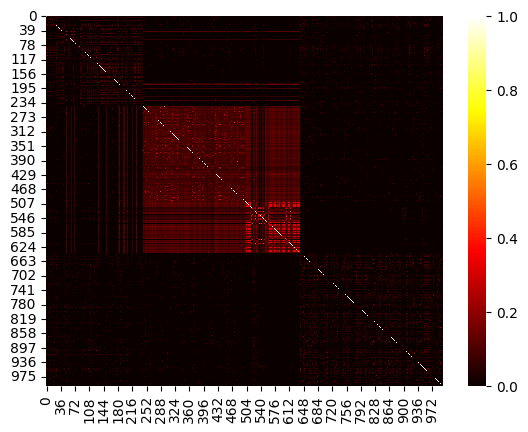

In [ ]:
sns.heatmap(lst_matrix, cmap='hot')
plt.show()

SVM Model

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

s = df4['label']

# Convert the series to a matrix
label_matrix = s.values

# Reshape the matrix if needed
label_matrix = label_matrix.reshape((1000,))

unique_val = np.unique(label_matrix)
print(unique_val)


[0 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lst_matrix, label_matrix, test_size=0.2, random_state=42)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
svm_acc = clf.score(X_test, y_test)
print("Accuracy of the model is:", svm_acc)

Accuracy of the model is: 0.945


Naive Bayes Classifier

In [ ]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)
print("Accuracy of the model is:", nb_acc)

Accuracy of the model is: 0.83


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)

print("Accuracy of the model is:", log_acc)


Accuracy of the model is: 0.9




```
# This is formatted as code
```

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print("Accuracy of the model is:", rf_acc)

Accuracy of the model is: 0.915


In [ ]:
!pip install tensorflow


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Assuming 'label' is the target column with categorical labels for classification
y = df['label']  # Target labels

# Convert target labels to categorical if they are not binary
y = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tf.toarray(), y, test_size=0.2, random_state=42)

# Define the ANN model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(256, activation='relu'))  # Hidden layer
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


Epoch 1/50
500/500 [==============================] - 4s 6ms/step - loss: 0.4229 - accuracy: 0.7779 - val_loss: 0.3458 - val_accuracy: 0.8188
Epoch 2/50
500/500 [==============================] - 3s 5ms/step - loss: 0.3179 - accuracy: 0.8415 - val_loss: 0.3452 - val_accuracy: 0.8110
Epoch 3/50
500/500 [==============================] - 2s 5ms/step - loss: 0.2776 - accuracy: 0.8646 - val_loss: 0.3500 - val_accuracy: 0.8217
Epoch 4/50
500/500 [==============================] - 2s 5ms/step - loss: 0.2397 - accuracy: 0.8836 - val_loss: 0.3795 - val_accuracy: 0.8145
Epoch 5/50
500/500 [==============================] - 2s 5ms/step - loss: 0.1945 - accuracy: 0.9103 - val_loss: 0.4092 - val_accuracy: 0.8167
Epoch 6/50
500/500 [==============================] - 3s 5ms/step - loss: 0.1620 - accuracy: 0.9254 - val_loss: 0.4937 - val_accuracy: 0.8150
Epoch 7/50
500/500 [==============================] - 3s 5ms/step - loss: 0.1359 - accuracy: 0.9383 - val_loss: 0.5147 - val_accuracy: 0.8158
Epoch 

KeyboardInterrupt: 

In [ ]:
!pip install optuna


In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to be tuned
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    neurons_layer1 = trial.suggest_int("neurons_layer1", 50, 512)
    neurons_layer2 = trial.suggest_int("neurons_layer2", 50, 512)
    dropout1 = trial.suggest_uniform("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_uniform("dropout2", 0.1, 0.5)

    # Build the model with suggested hyperparameters
    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout1),
        Dense(neurons_layer2, activation='relu'),
        Dropout(dropout2),
        Dense(y.shape[1], activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Return accuracy for Optuna to maximize
    return accuracy

# Step 3: Run the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Display the best hyperparameters and best accuracy found
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Best hyperparameters from Optuna
best_params = {
    'learning_rate': 0.0008749334351850515,
    'neurons_layer1': 161,
    'neurons_layer2': 437,
    'dropout1': 0.40449289524206694,
    'dropout2': 0.13053022899986386
}

# Define and compile the final model with optimized hyperparameters
final_model = Sequential([
    Dense(best_params['neurons_layer1'], activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(best_params['dropout1']),
    Dense(best_params['neurons_layer2'], activation='relu'),
    Dropout(best_params['dropout2']),
    Dense(y.shape[1], activation='softmax')
])

# Compile with optimized learning rate
final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the final model
history = final_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {test_accuracy}")
print(f"Final Test Loss: {test_loss}")


In [ ]:
from tensorflow.keras.layers import LeakyReLU

# Example of adding layers and using LeakyReLU
model = Sequential([
    Dense(200, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(150),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from sklearn.model_selection import train_test_split
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
SEED = 10

In [ ]:
from keras.layers import Embedding


In [ ]:
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

X = df['post_text']
y = df['label']

<ipython-input-51-dc97eaefd5a1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of Target')

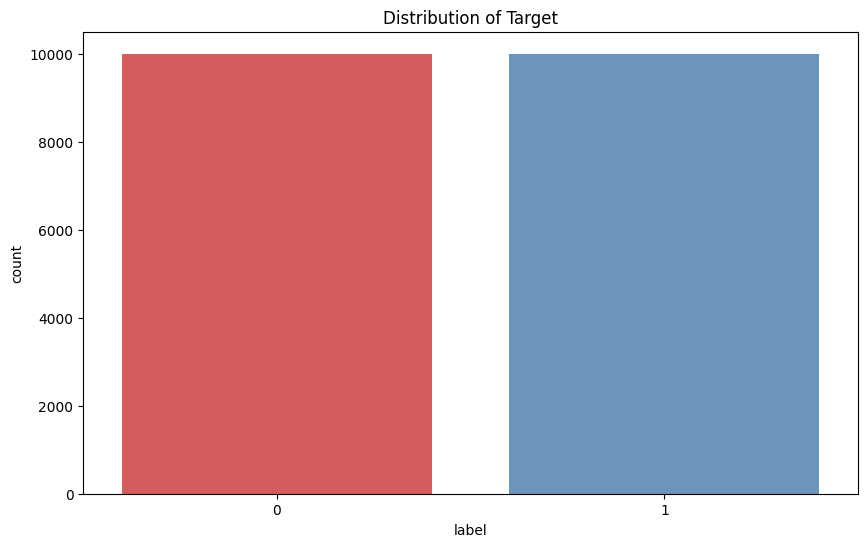

In [ ]:
plt.figure(figsize = (10,6))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Target')


<ipython-input-52-08f8f6e17081>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins = range(1, 40, 2), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of the Word Count')

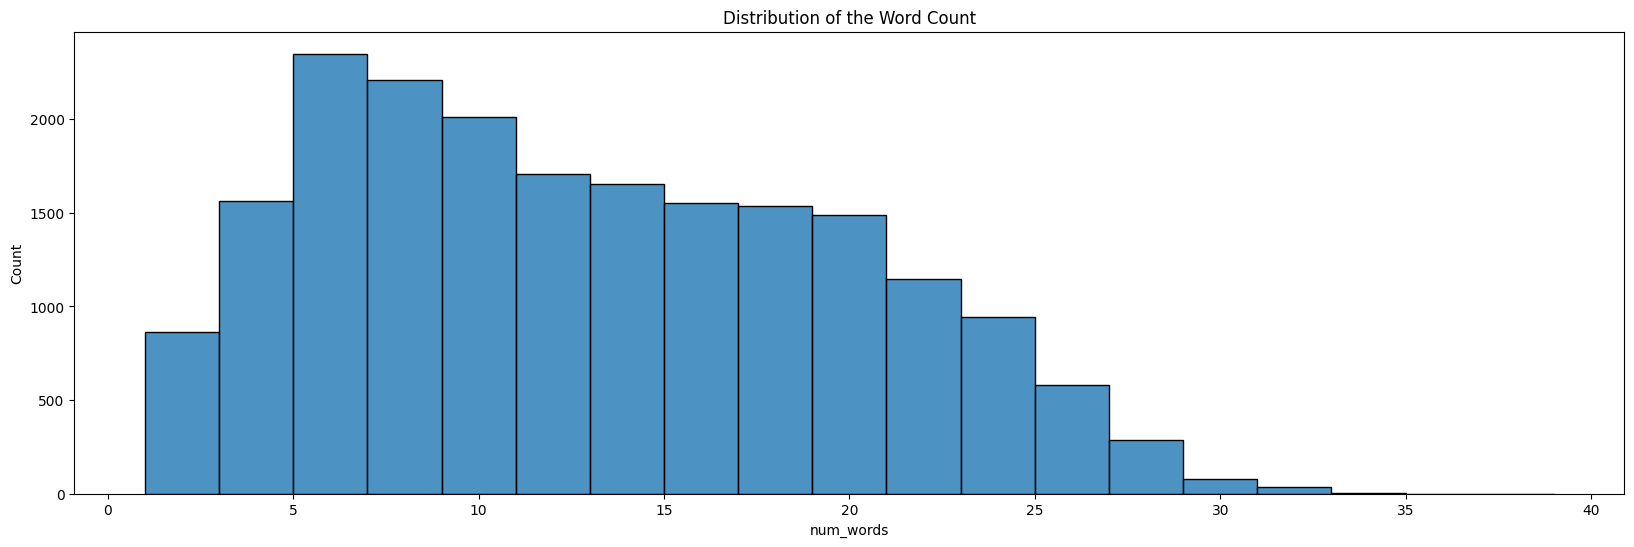

In [ ]:
df['num_words'] = df['post_text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (20,6))
sns.histplot(df['num_words'], bins = range(1, 40, 2), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the Word Count')


In [ ]:
#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = SEED)



In [ ]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')


Train vocabulary size: 28937


In [ ]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 40

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)



In [ ]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           3703936   
                                                                 
 bidirectional (Bidirection  (None, 40, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB
None


<ipython-input-59-0cb10b01e95a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set1', alpha=0.8)


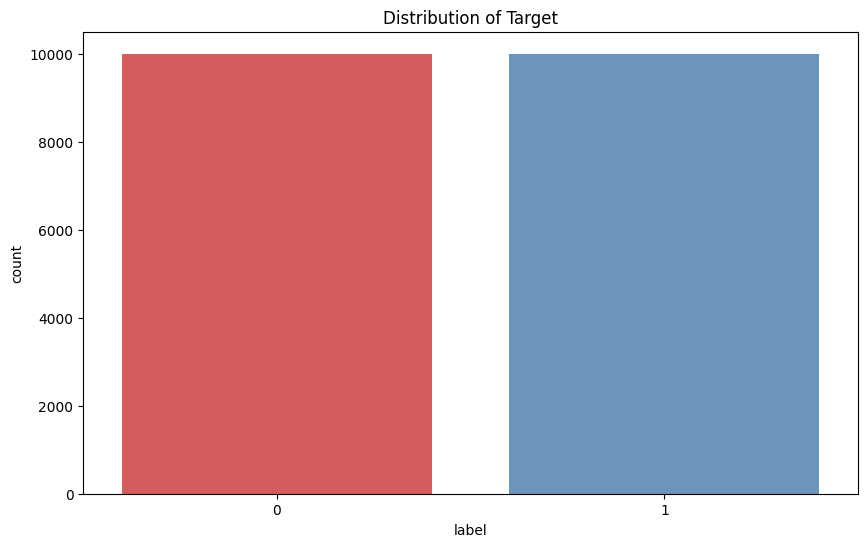

<ipython-input-59-0cb10b01e95a>:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)


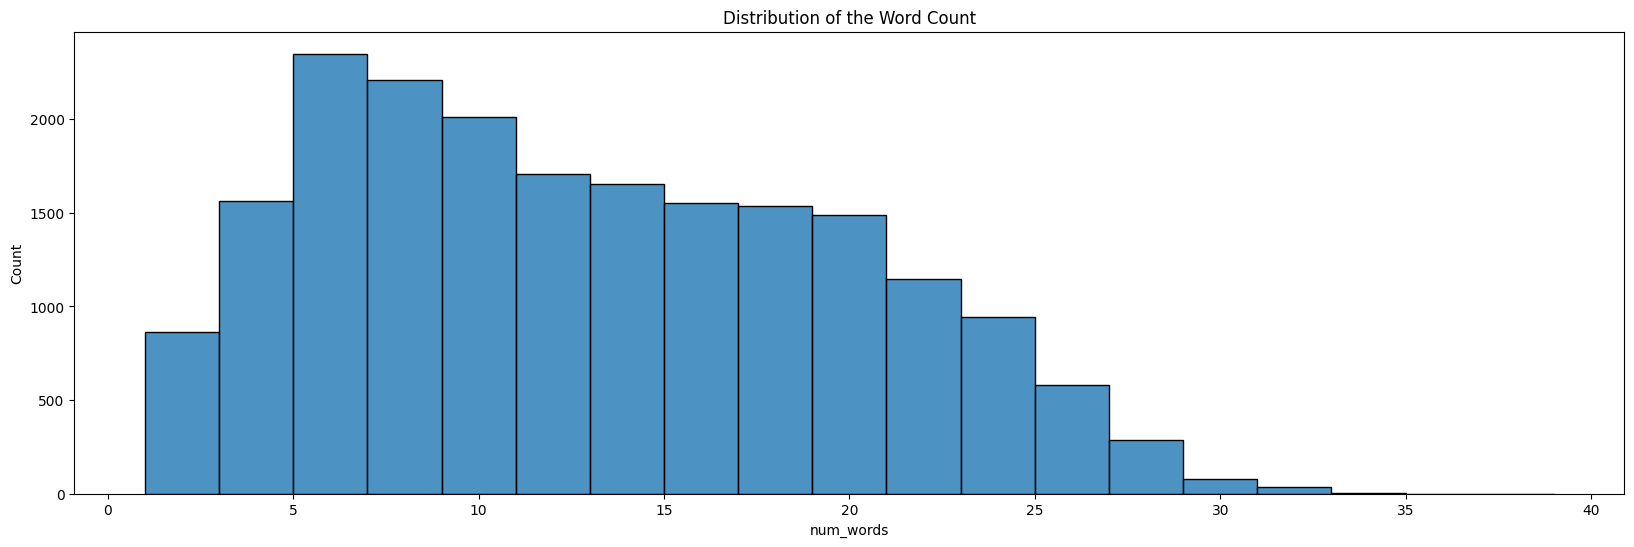

Train vocabulary size: 28906
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 128)           3699968   
                                                                 
 bidirectional_2 (Bidirecti  (None, 40, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)         

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Check the data structure and information
print(df.info())

# Extract features and target variable
X = df['post_text']
y = df['label']

# Visualize the distribution of labels
plt.figure(figsize=(10,6))
sns.countplot(x=df['label'], palette='Set1', alpha=0.8)
plt.title('Distribution of Target')
plt.show()

# Calculate and visualize the distribution of word count per post
df['num_words'] = df['post_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(20,6))
sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)
plt.title('Distribution of the Word Count')
plt.show()

# Split the dataset into training and test sets
SEED = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

# Define and fit the Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Print the size of the vocabulary
vocab_size = len(tok.word_index) + 1  # Adding 1 to include zero padding in the vocabulary
print(f'Train vocabulary size: {vocab_size}')

# Define the maximum sequence length based on distribution analysis
MAX_LEN = 40  # Or adjust based on the word distribution plot

# Pad sequences to ensure uniform input size
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                               verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB
None


<ipython-input-60-0cb10b01e95a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set1', alpha=0.8)


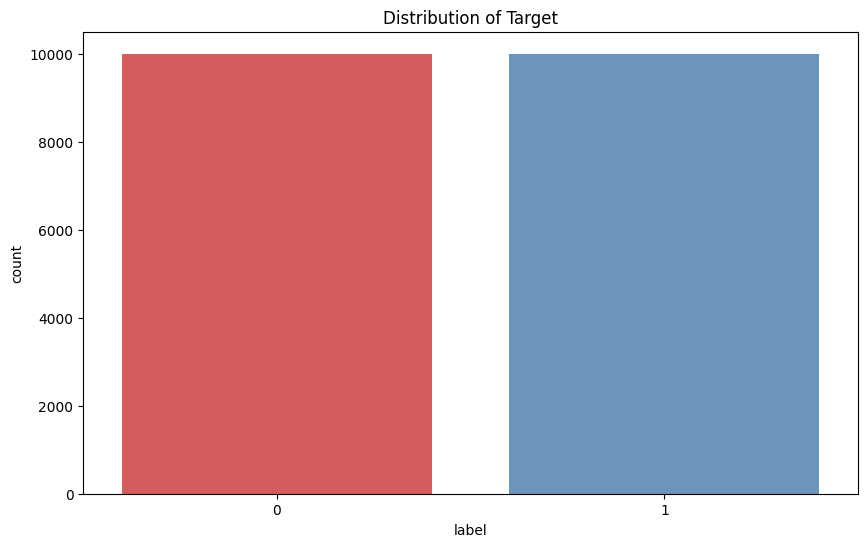

<ipython-input-60-0cb10b01e95a>:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)


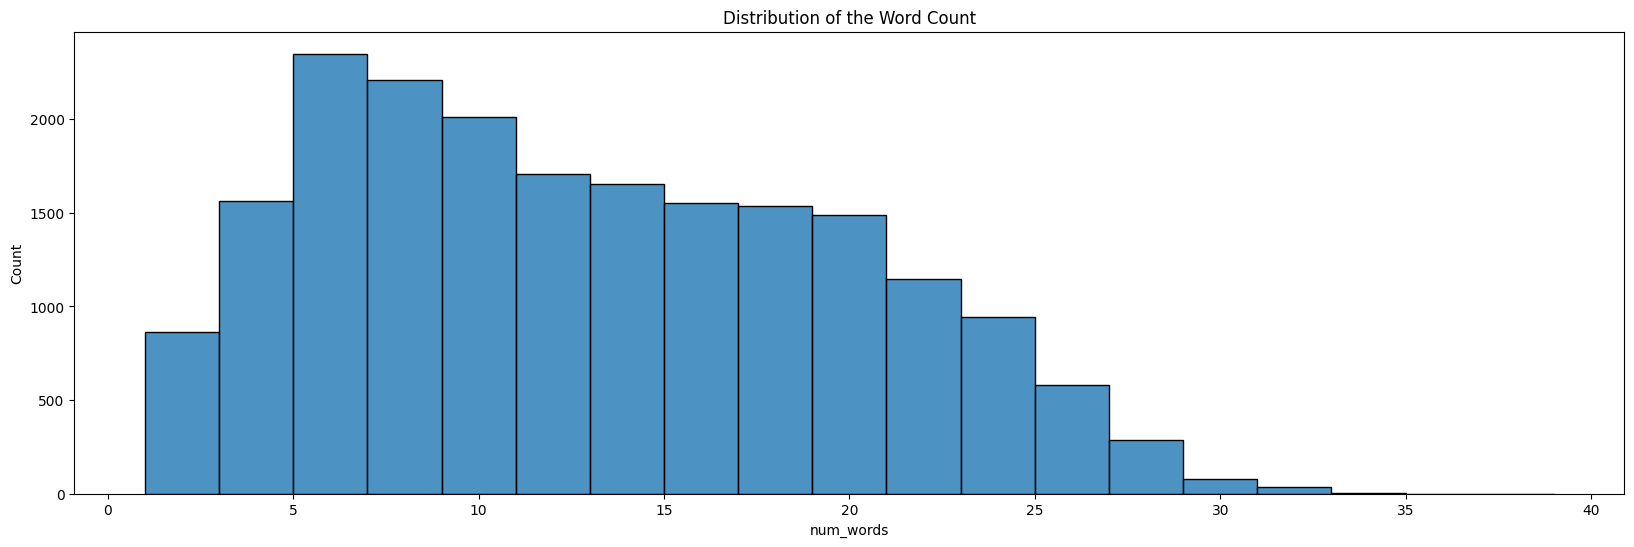

Train vocabulary size: 28906
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 128)           3699968   
                                                                 
 bidirectional_4 (Bidirecti  (None, 40, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)         

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Check the data structure and information
print(df.info())

# Extract features and target variable
X = df['post_text']
y = df['label']

# Visualize the distribution of labels
plt.figure(figsize=(10,6))
sns.countplot(x=df['label'], palette='Set1', alpha=0.8)
plt.title('Distribution of Target')
plt.show()

# Calculate and visualize the distribution of word count per post
df['num_words'] = df['post_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(20,6))
sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)
plt.title('Distribution of the Word Count')
plt.show()

# Split the dataset into training and test sets
SEED = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

# Define and fit the Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Print the size of the vocabulary
vocab_size = len(tok.word_index) + 1  # Adding 1 to include zero padding in the vocabulary
print(f'Train vocabulary size: {vocab_size}')

# Define the maximum sequence length based on distribution analysis
MAX_LEN = 40  # Or adjust based on the word distribution plot

# Pad sequences to ensure uniform input size
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                               verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')


157/157 [==============================] - 2s 12ms/step - loss: 0.3019 - accuracy: 0.8764

Test Loss: 0.30190253257751465, Test Accuracy: 0.8763999938964844
157/157 [==============================] - 3s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2500
           1       0.87      0.88      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



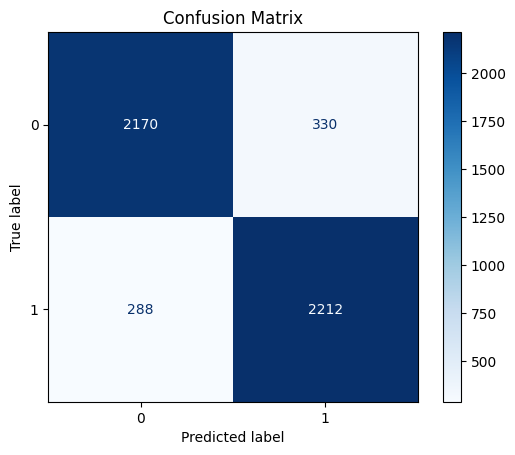

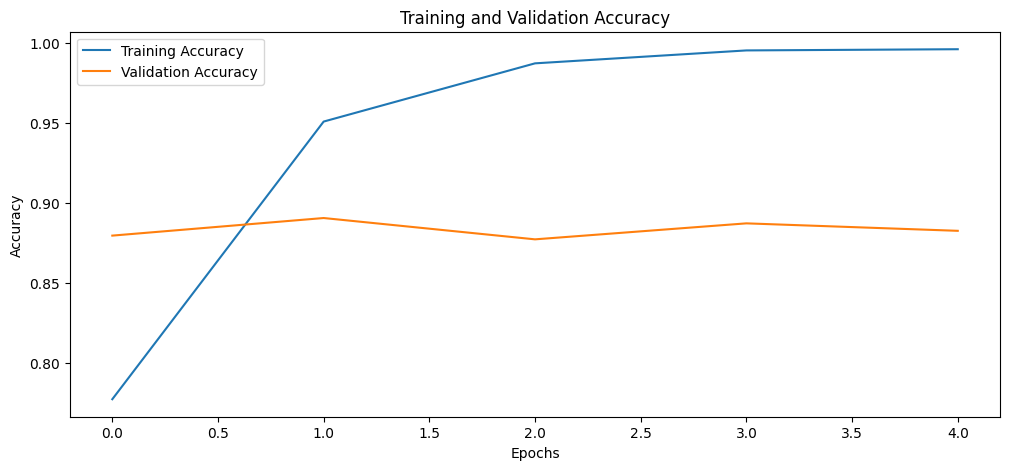

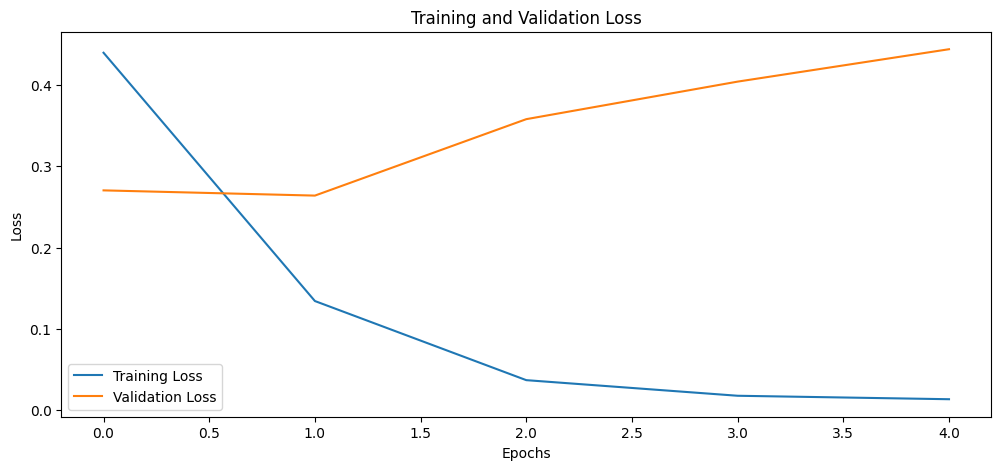

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB
None


<ipython-input-62-ce63e608c967>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set1', alpha=0.8)


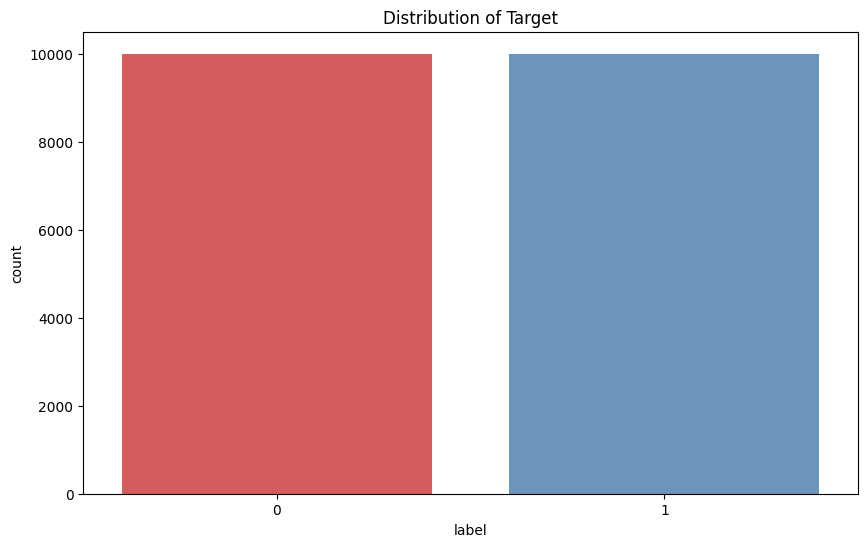

<ipython-input-62-ce63e608c967>:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)


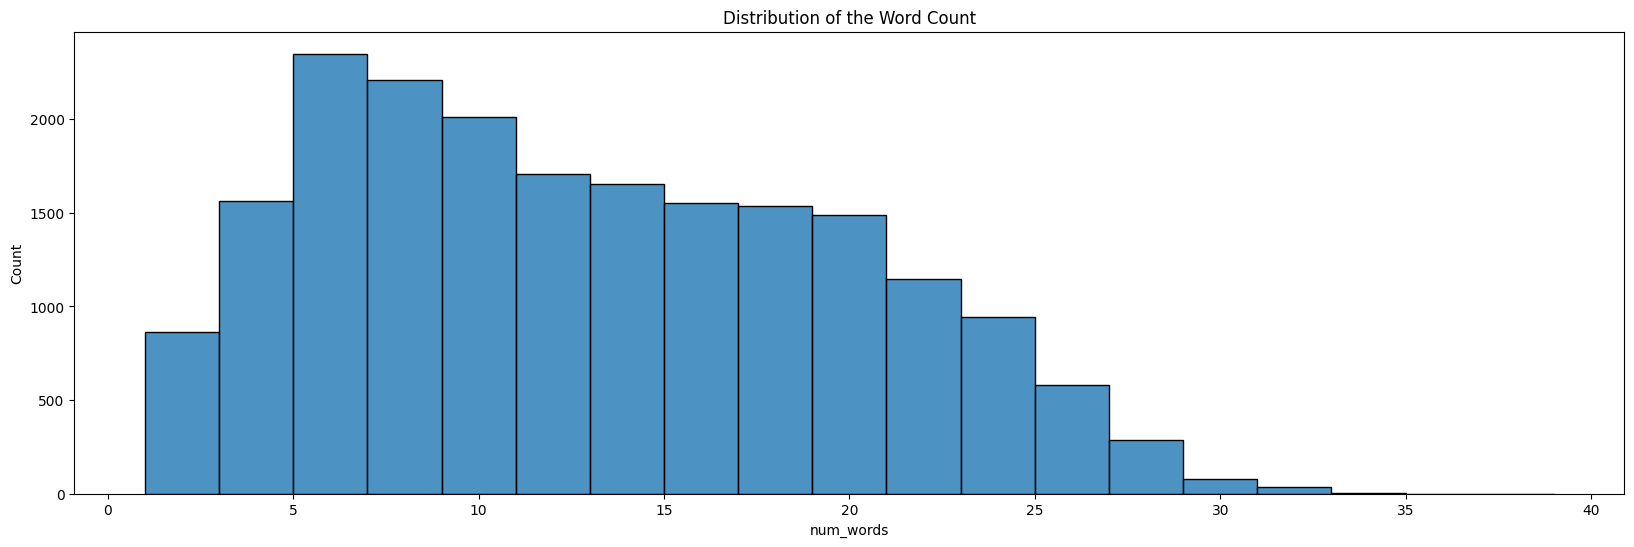

Train vocabulary size: 28906
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 128)           3699968   
                                                                 
 bidirectional_6 (Bidirecti  (None, 40, 128)           98816     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)        

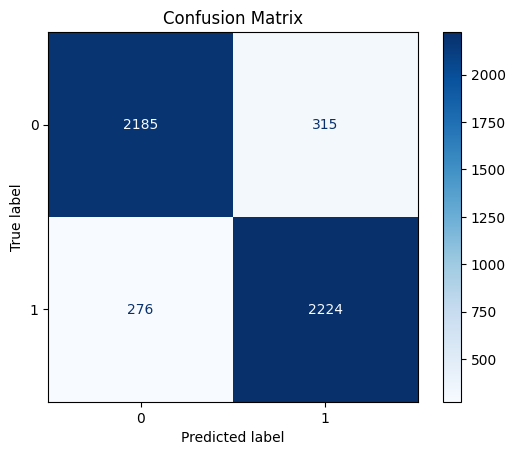

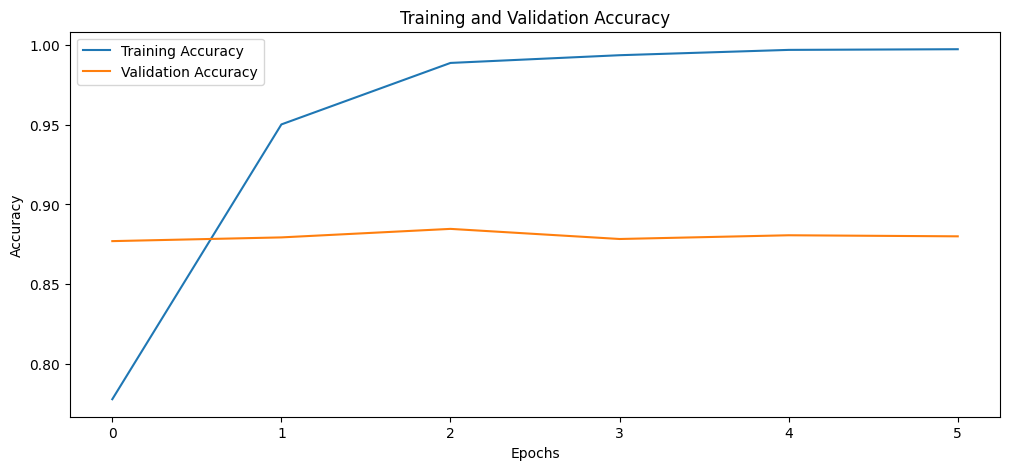

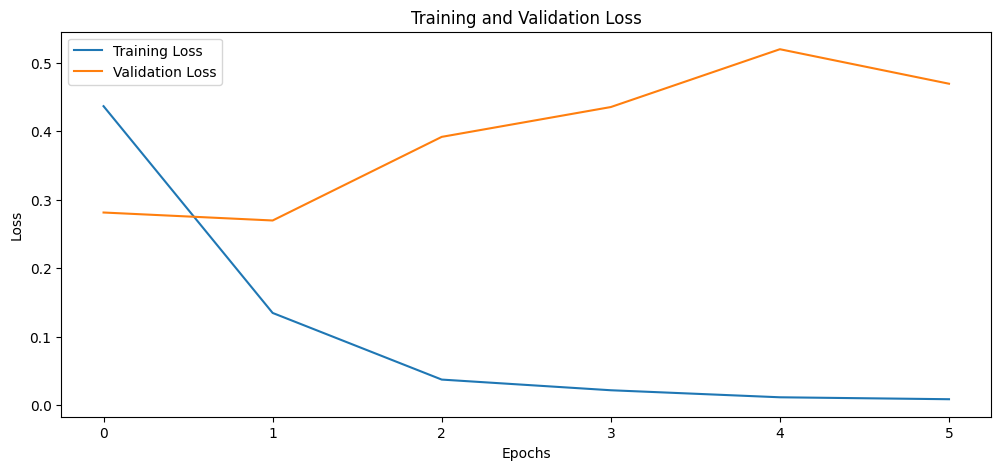

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Check the data structure and information
print(df.info())

# Extract features and target variable
X = df['post_text']
y = df['label']

# Visualize the distribution of labels
plt.figure(figsize=(10,6))
sns.countplot(x=df['label'], palette='Set1', alpha=0.8)
plt.title('Distribution of Target')
plt.show()

# Calculate and visualize the distribution of word count per post
df['num_words'] = df['post_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(20,6))
sns.histplot(df['num_words'], bins=range(1, 40, 2), palette='Set1', alpha=0.8)
plt.title('Distribution of the Word Count')
plt.show()

# Split the dataset into training and test sets
SEED = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

# Define and fit the Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Print the size of the vocabulary
vocab_size = len(tok.word_index) + 1  # Adding 1 to include zero padding in the vocabulary
print(f'Train vocabulary size: {vocab_size}')

# Define the maximum sequence length based on distribution analysis
MAX_LEN = 40  # Or adjust based on the word distribution plot

# Pad sequences to ensure uniform input size
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                               verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 128)           3699968   
                                                                 
 conv1d (Conv1D)             (None, 38, 64)            24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 64)            0         
 D)                                                              
                                                                 
 bidirectional_8 (Bidirecti  (None, 19, 128)           66048     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                      

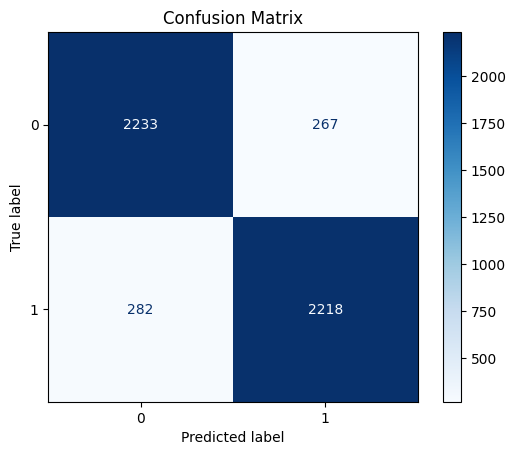

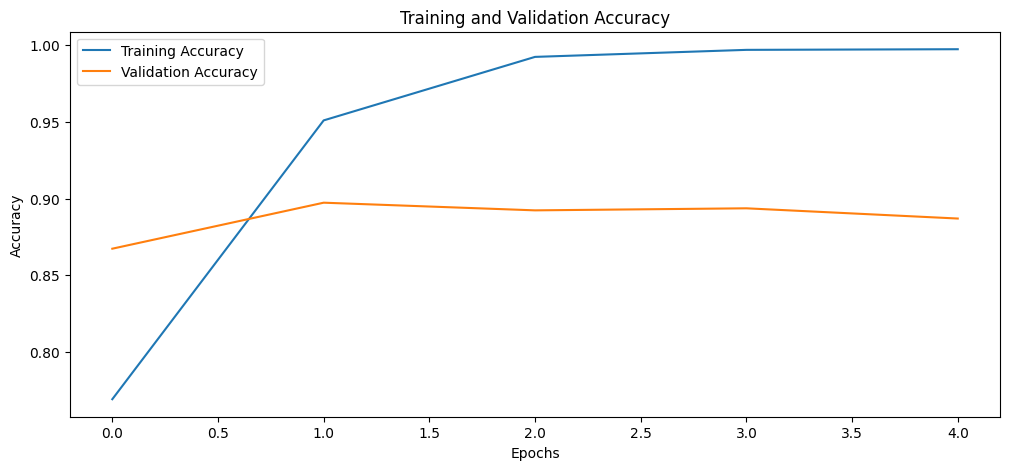

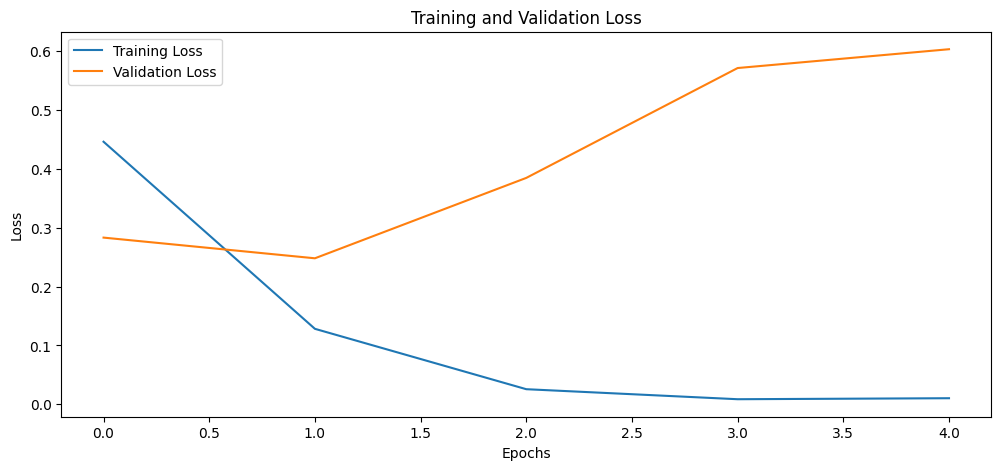

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Extract features and target variable
X = df['post_text']
y = df['label']

# Split the dataset into training and test sets
SEED = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

# Define and fit the Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Set vocabulary size and padding length
vocab_size = len(tok.word_index) + 1  # Adding 1 to include zero padding in the vocabulary
MAX_LEN = 40  # Adjust based on your dataset

# Pad sequences to ensure uniform input size
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the hybrid model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(input_dim=vocab_size, output_dim=128),

    # Add convolutional layers for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Add LSTM layers for sequence processing
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,
                               verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=15,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 128)           3699968   
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 64)            24640     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 19, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_12 (Bidirect  (None, 19, 128)           66048     
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                      

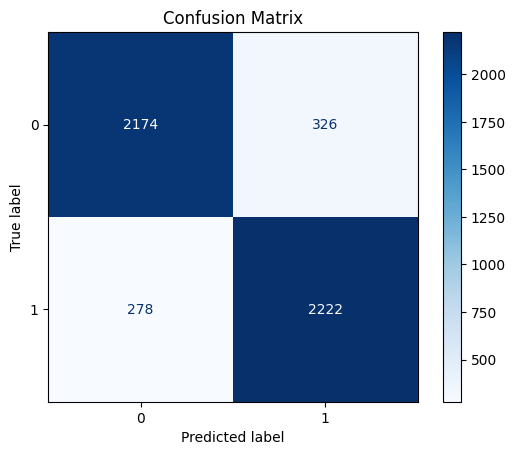

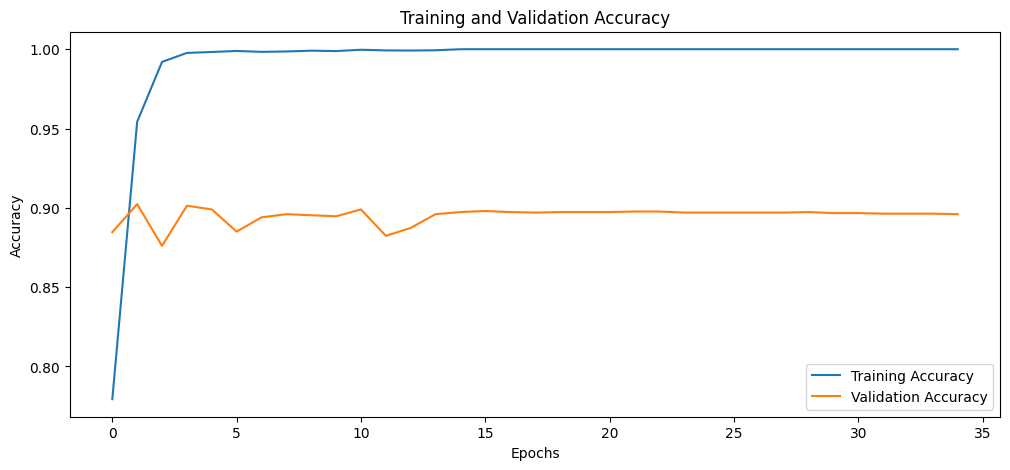

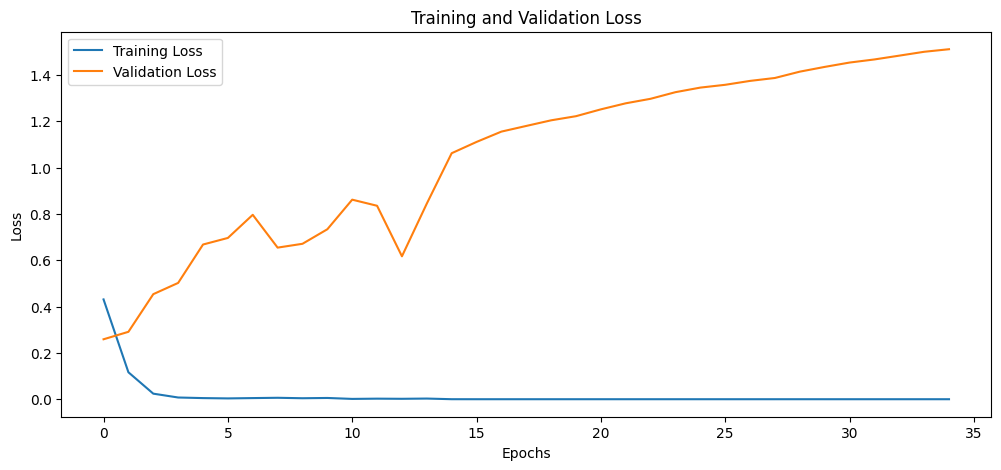

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Extract features and target variable
X = df['post_text']
y = df['label']

# Split the dataset into training and test sets
SEED = 42  # Set a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

# Define and fit the Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Set vocabulary size and padding length
vocab_size = len(tok.word_index) + 1  # Adding 1 to include zero padding in the vocabulary
MAX_LEN = 40  # Adjust based on your dataset

# Pad sequences to ensure uniform input size
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the hybrid model architecture
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(input_dim=vocab_size, output_dim=128),

    # Add convolutional layers for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Add LSTM layers for sequence processing
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping
# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=35,
                    validation_split=0.2,
                    batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 40)]                 0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 40, 128)              3699968   ['inputs[0][0]']              
                                                                                                  
 conv1d_10 (Conv1D)          (None, 40, 64)               24640     ['embedding_11[0][0]']        
                                                                                                  
 batch_normalization_1 (Bat  (None, 40, 64)               256       ['conv1d_10[0][0]']           
 chNormalization)                                                                           

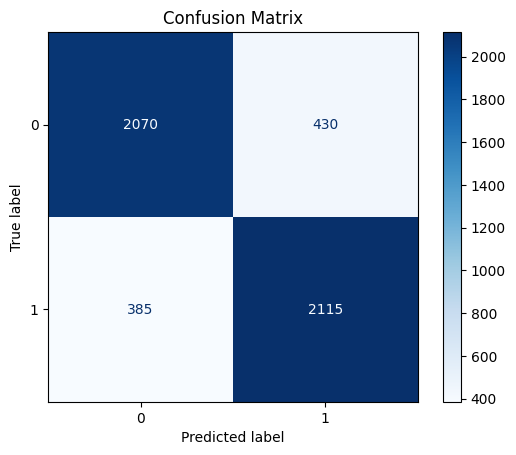

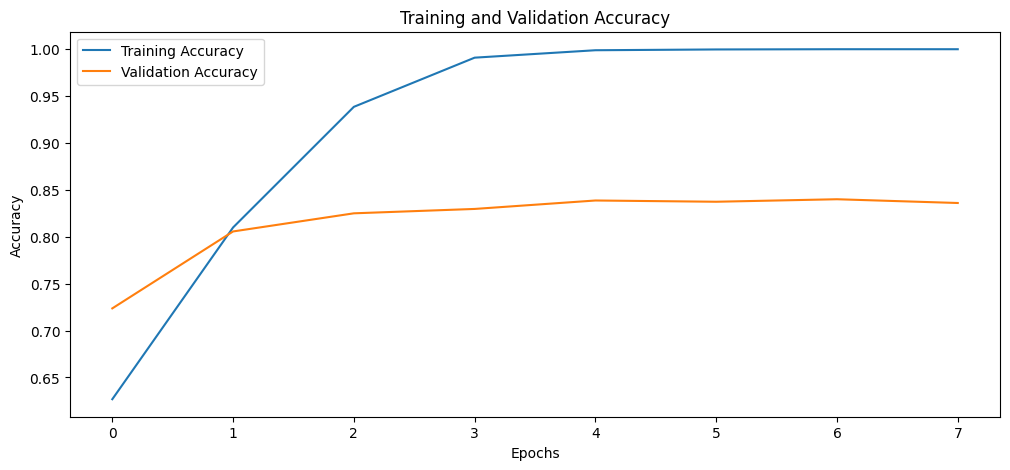

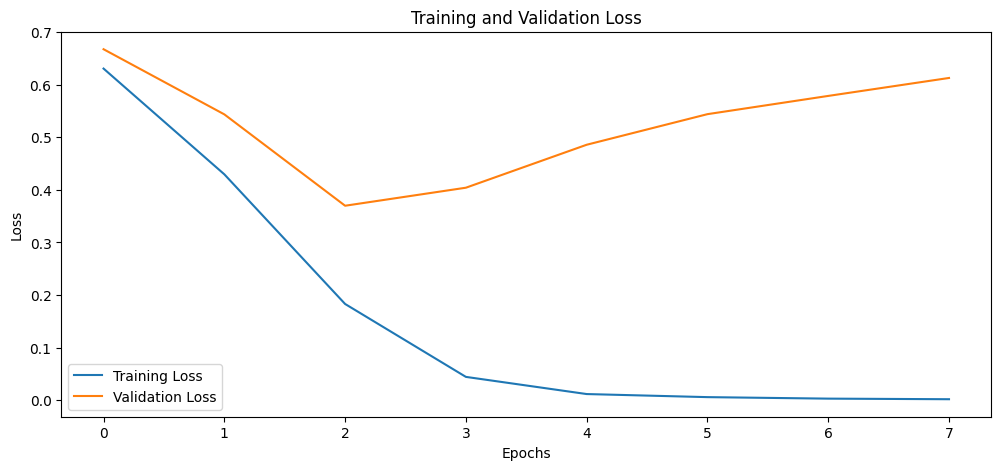

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Multiply, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define attention mechanism
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    output = Multiply()([inputs, attention])
    return output

# Define the hybrid model architecture
inputs = Input(shape=(MAX_LEN,), name="inputs")
x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)

# Convolutional Block
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = GlobalMaxPooling1D()(x)

# LSTM Block with Attention
x = tf.keras.layers.Reshape((1, -1))(x)  # Reshape for attention compatibility
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = attention_block(x)
x = tf.keras.layers.Flatten()(x)

# Fully connected layers with dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Model creation
model = Model(inputs, outputs)

# Choose an optimizer
# optimizer = Adam(learning_rate=1e-4)
optimizer = AdamW(learning_rate=1e-4)  # Uncomment for AdamW
# optimizer = RMSprop(learning_rate=1e-4)  # Uncomment for RMSprop
# optimizer = Nadam(learning_rate=1e-4)  # Uncomment for Nadam

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=30,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 40)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 40, 128)              3699968   ['inputs[0][0]']              
                                                                                                  
 conv1d_12 (Conv1D)          (None, 40, 64)               24640     ['embedding_12[0][0]']        
                                                                                                  
 batch_normalization_2 (Bat  (None, 40, 64)               256       ['conv1d_12[0][0]']           
 chNormalization)                                                                           

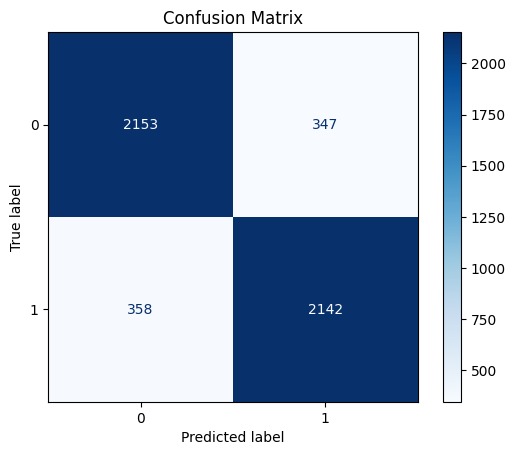

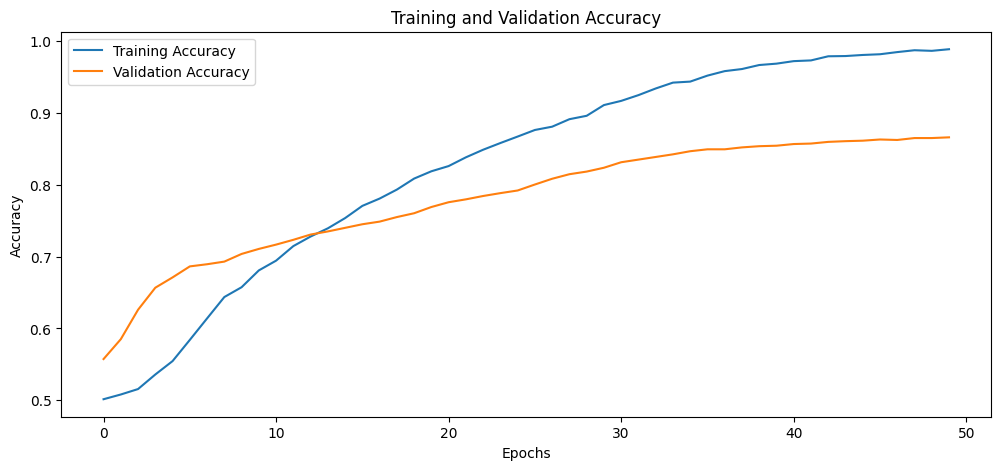

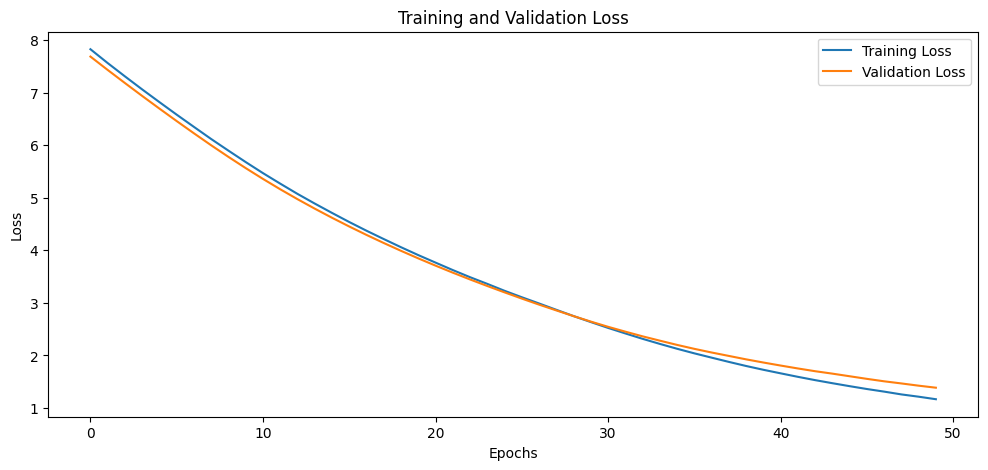

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Multiply, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define attention mechanism
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    output = Multiply()([inputs, attention])
    return output

# Define the hybrid model architecture with L2 regularization and higher dropout
inputs = Input(shape=(MAX_LEN,), name="inputs")
x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)

# Convolutional Block
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = GlobalMaxPooling1D()(x)

# LSTM Block with Attention
x = tf.keras.layers.Reshape((1, -1))(x)  # Reshape for attention compatibility
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
x = attention_block(x)
x = tf.keras.layers.Flatten()(x)

# Fully connected layers with increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
outputs = Dense(1, activation='sigmoid')(x)

# Model creation and compilation
model = Model(inputs, outputs)
optimizer = AdamW(learning_rate=1e-5)  # Reduced learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=50,  # Increased epochs to give more time for improvement
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 128)        │      3,699,968 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 40, 64)         │         24,640 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 40, 64)         │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 40, 128)        │         24,704 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 128)         │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 128)         │         98,816 │ reshape[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1)           │            129 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1)              │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1)              │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 128, 1)         │              0 │ activation[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 1, 128)         │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1, 128)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,512 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_1[0][0]          │
├──────────────────────

 Total params: 3,873,346 (14.78 MB)

 Trainable params: 3,873,218 (14.78 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.5046 - loss: 7.8861 - val_accuracy: 0.5783 - val_loss: 7.6872
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.5130 - loss: 7.6269 - val_accuracy: 0.5990 - val_loss: 7.4350
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.5132 - loss: 7.3756 - val_accuracy: 0.6250 - val_loss: 7.1883
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.5324 - loss: 7.1293 - val_accuracy: 0.6540 - val_loss: 6.9463
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.5476 - loss: 6.8899 - val_accuracy: 0.6830 - val_loss: 6.7102
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.5518 - loss: 6.6594 - val_accuracy: 0.6863 - val_loss: 6.4797
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.5910 - loss: 6.4280 - val_accuracy: 0.6907 - val_loss: 6.2530
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.6304 - loss: 6.2019 - val_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2500
           1       0.88      0.86      0.87      2500

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



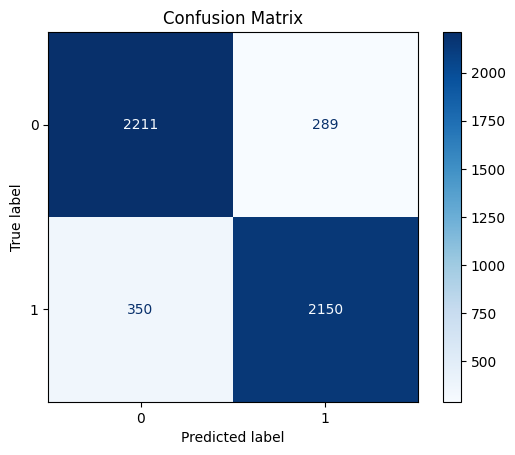

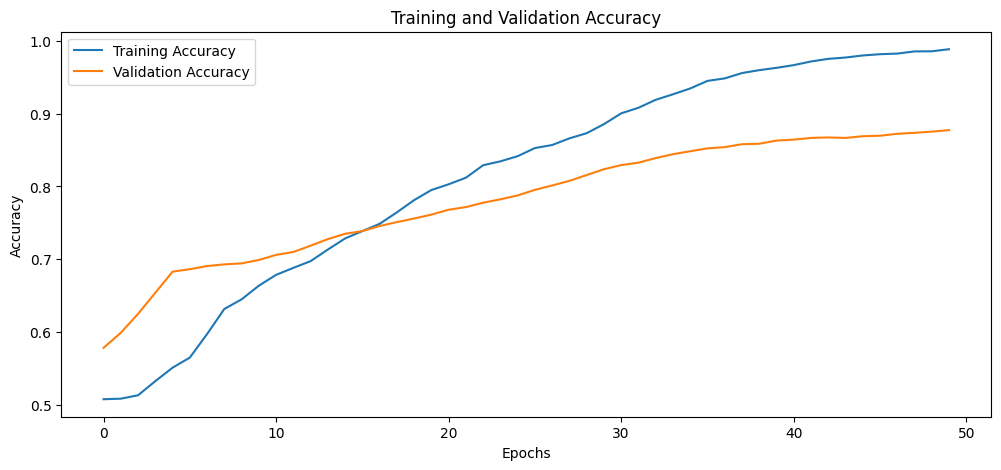

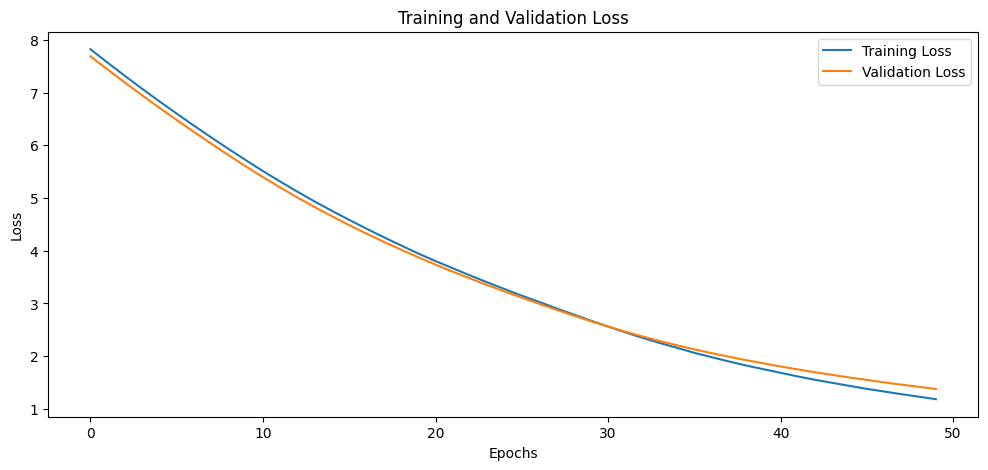

In [ ]:
 import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Multiply, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define attention mechanism
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    output = Multiply()([inputs, attention])
    return output

# Define the hybrid model architecture with L2 regularization and higher dropout
inputs = Input(shape=(MAX_LEN,), name="inputs")
x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)

# Convolutional Block
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = GlobalMaxPooling1D()(x)

# LSTM Block with Attention
x = tf.keras.layers.Reshape((1, -1))(x)  # Reshape for attention compatibility
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
x = attention_block(x)
x = tf.keras.layers.Flatten()(x)

# Fully connected layers with increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
outputs = Dense(1, activation='sigmoid')(x)

# Model creation and compilation
model = Model(inputs, outputs)
optimizer = AdamW(learning_rate=1e-5)  # Reduced learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=50,  # Increased epochs to give more time for improvement
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 40, 128)        │      3,699,968 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 40, 64)         │         24,640 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 40, 64)         │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 40, 128)        │         24,704 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 128)         │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 1, 128)         │         98,816 │ reshape_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 1)           │            129 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1)              │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1)              │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 128, 1)         │              0 │ activation_1[0][0]     │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_1 (Permute)       │ (None, 1, 128)         │              0 │ repeat_vector_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 1, 128)         │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ permute_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 128)            │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         16,512 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├──────────────────────

 Total params: 3,873,346 (14.78 MB)

 Trainable params: 3,873,218 (14.78 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.5082 - loss: 7.8663 - val_accuracy: 0.5750 - val_loss: 7.6603
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.5160 - loss: 7.5953 - val_accuracy: 0.6120 - val_loss: 7.3962
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5220 - loss: 7.3316 - val_accuracy: 0.6567 - val_loss: 7.1377
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.5437 - loss: 7.0739 - val_accuracy: 0.6750 - val_loss: 6.8828
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.5675 - loss: 6.8229 - val_accuracy: 0.6867 - val_loss: 6.6345
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.5877 - loss: 6.5795 - val_accuracy: 0.6903 - val_loss: 6.3940
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.6120 - loss: 6.3437 - val_accuracy: 0.6897 - val_loss: 6.1617
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.6305 - loss: 6.1145 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2500
           1       0.91      0.87      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



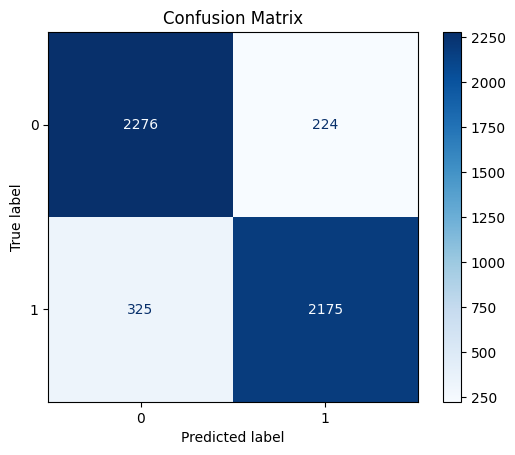

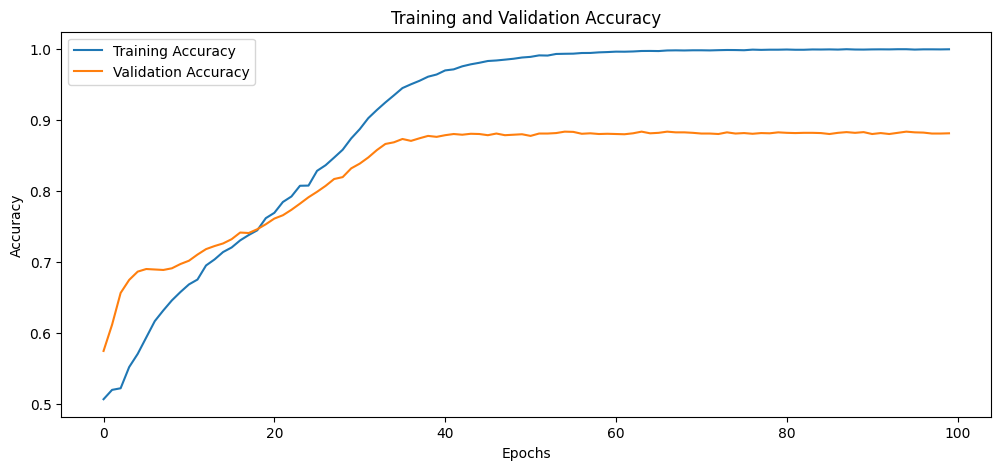

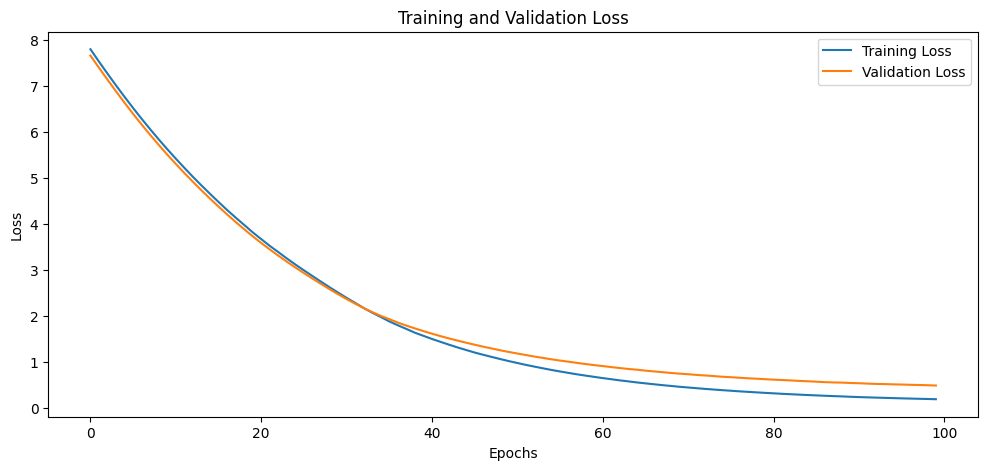

In [ ]:
 import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Multiply, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define attention mechanism
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    output = Multiply()([inputs, attention])
    return output

# Define the hybrid model architecture with L2 regularization and higher dropout
inputs = Input(shape=(MAX_LEN,), name="inputs")
x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)

# Convolutional Block
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = GlobalMaxPooling1D()(x)

# LSTM Block with Attention
x = tf.keras.layers.Reshape((1, -1))(x)  # Reshape for attention compatibility
x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(x)
x = attention_block(x)
x = tf.keras.layers.Flatten()(x)

# Fully connected layers with increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)  # Increased dropout
outputs = Dense(1, activation='sigmoid')(x)

# Model creation and compilation
model = Model(inputs, outputs)
optimizer = AdamW(learning_rate=1e-5)  # Reduced learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=100,  # Increased epochs to give more time for improvement
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Predictions and classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(12, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


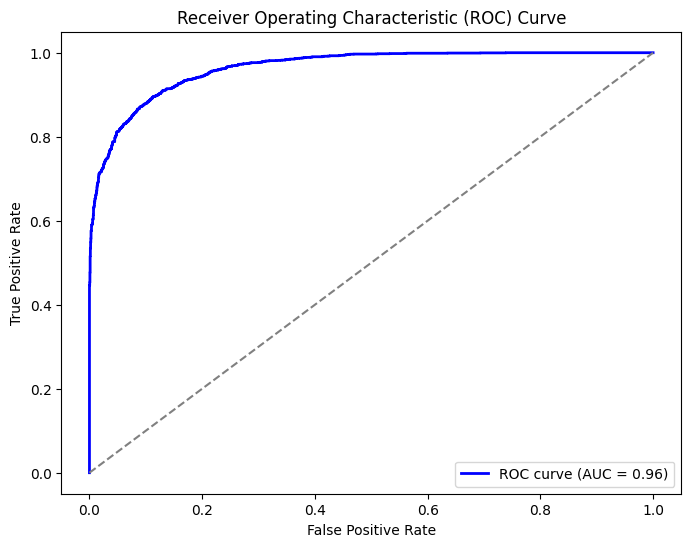

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get model predictions as probabilities
y_prob = model.predict(X_test_seq).ravel()  # Flatten the probabilities for ROC curve

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the Transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, inputs])
    return x

# CNN Model
def create_cnn_model():
    inputs = Input(shape=(MAX_LEN,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Bi-LSTM Model
def create_lstm_model():
    inputs = Input(shape=(MAX_LEN,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Transformer Model
def create_transformer_model():
    inputs = Input(shape=(MAX_LEN,))
    x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Instantiate models
cnn_model = create_cnn_model()
lstm_model = create_lstm_model()
transformer_model = create_transformer_model()

# Compile models
optimizer = AdamW(learning_rate=1e-5)
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lstm_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
transformer_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train each model
cnn_model.fit(X_train_seq, y_train, epochs=20, validation_split=0.2, batch_size=64, callbacks=[early_stopping])
lstm_model.fit(X_train_seq, y_train, epochs=20, validation_split=0.2, batch_size=64, callbacks=[early_stopping])
transformer_model.fit(X_train_seq, y_train, epochs=20, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

# Generate predictions and ensemble them by averaging
cnn_pred = cnn_model.predict(X_test_seq)
lstm_pred = lstm_model.predict(X_test_seq)
transformer_pred = transformer_model.predict(X_test_seq)

# Averaging the predictions from each model
ensemble_pred = (cnn_pred + lstm_pred + transformer_pred) / 3
ensemble_pred = (ensemble_pred > 0.5).astype("int32")

# Evaluate ensemble performance
print("\nEnsemble Classification Report:")
print(classification_report(y_test, ensemble_pred))

accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.5020 - loss: 1.5494 - val_accuracy: 0.5477 - val_loss: 1.5285
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.5380 - loss: 1.5214 - val_accuracy: 0.6357 - val_loss: 1.5008
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.5725 - loss: 1.4940 - val_accuracy: 0.6860 - val_loss: 1.4724
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.6361 - loss: 1.4644 - val_accuracy: 0.6930 - val_loss: 1.4416
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6669 - loss: 1.4330 - val_accuracy: 0.6993 - val_loss: 1.4084
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.6877 - loss: 1.3995 - val_accuracy: 0.6947 - val_loss: 1.3732
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.6929 - loss: 1.3645 - val_accuracy: 0.6957 - val_loss: 1.3359
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.6879 - loss: 1.3278 - 

ValueError: Unknown variable: <KerasVariable shape=(28906, 128), dtype=float32, path=embedding_3/embeddings>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Mental-Health-Twitter.csv')

# Prepare the data
X = df['post_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Tokenize and pad sequences
tok = Tokenizer()
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

vocab_size = len(tok.word_index) + 1
MAX_LEN = 40
X_train_seq = sequence.pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences, maxlen=MAX_LEN)

# Define the RNN-LSTM hybrid model architecture
inputs = Input(shape=(MAX_LEN,), name="inputs")
x = Embedding(input_dim=vocab_size, output_dim=128)(inputs)

# RNN layer
x = SimpleRNN(64, return_sequences=True)(x)

# LSTM layer
x = LSTM(64, return_sequences=True)(x)

# Global Max Pooling to reduce dimensions and flatten
x = GlobalMaxPooling1D()(x)

# Fully connected layers with dropout for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Model creation and compilation
model = Model(inputs, outputs)
optimizer = Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping to prevent overfitting

# Train the model
history = model.fit(X_train_seq, y_train,
                    epochs=100,
                    validation_split=0.2,
                    batch_size=64
                )

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test)
print(f'\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Generate predictions and display a classification report
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 40, 128)             │       3,699,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 40, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 40, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,751,617 (14.31 MB)

 Trainable params: 3,751,617 (14.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.5109 - loss: 0.6924 - val_accuracy: 0.6573 - val_loss: 0.6709
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.6722 - loss: 0.6296 - val_accuracy: 0.8173 - val_loss: 0.4065
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.8546 - loss: 0.3712 - val_accuracy: 0.8517 - val_loss: 0.3315
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9338 - loss: 0.2054 - val_accuracy: 0.8620 - val_loss: 0.3182
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9626 - loss: 0.1221 - val_accuracy: 0.8537 - val_loss: 0.4156
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9751 - loss: 0.0813 - val_accuracy: 0.8670 - val_loss: 0.4018
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9838 - loss: 0.0553 - val_accuracy: 0.8730 - val_loss: 0.4513
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.9900 - loss:

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-1a3bc09a3a87>", line 62, in <cell line: 62>
    history = model.fit(X_train_seq, y_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eag

TypeError: object of type 'NoneType' has no len()